In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from keras.models import Model
from deel.lip.layers import (
    SpectralDense,
    SpectralConv2D,
    ScaledL2NormPooling2D,
    FrobeniusDense,
)
from deel.lip.model import Sequential
from deel.lip.activations import GroupSort, FullSort

np.random.seed(123)

/home/wulab/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-01-11 17:02:11.346444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 17:02:11.459591: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-11 17:02:11.484470: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
from collections import deque
from queue import PriorityQueue
from cvxopt import matrix, solvers
from copy import deepcopy
import time
import math


# In[2]:


#rounding down/up for lower/upper bounds of intervals

def rdn(a):
    return round(a-(5e-16),15)
def rup(a):
    return round(a+(5e-16),15)


# In[3]:


#matrix and interval operations

def ii_add(a,b):
    return [rdn(a[0]+b[0]),rup(a[1]+b[1])]

def ii_mul(a,b):
    mn=min(rdn(a[0]*b[0]),rdn(a[0]*b[1]),rdn(a[1]*b[0]),rdn(a[1]*b[1]))
    mx=max(rup(a[0]*b[0]),rup(a[0]*b[1]),rup(a[1]*b[0]),rup(a[1]*b[1]))
    return [mn,mx]

def ic_mul(a,b):    
    return [min(rdn(b*a[0]),rdn(b*a[1])),max(rup(b*a[0]),rup(b*a[1]))]

def mm_mul(m1,m2):
    m=[[0 for j in range(len(m2[0]))] for i in range(len(m1))]
    for i in range(len(m1)):
        for j in range(len(m2[0])):
            for k in range(len(m2)):
                m[i][j]+=m1[i][k]*m2[k][j]
    return m

def mv_spmul(m1,m2):
    m=[[0 for j in range(len(m2))] for i in range(len(m1))]
    for i in range(len(m2)):
        for j in range(len(m1)):
            m[j][i]=m1[j][i]*m2[i][0]
    return m

def mim_mul(m1,m2):
    m=[[[0,0] for j in range(len(m2[0]))] for i in range(len(m1))]
    for i in range(len(m1)):
        for j in range(len(m2[0])):
            for k in range(len(m2)):
                m[i][j]=ii_add(m[i][j], ic_mul(m2[k][j],m1[i][k]))
    return m

def ivim_spmul(m1,m2):
    m=[[[0,0] for j in range(len(m2[0]))] for i in range(len(m1))]
    for i in range(len(m1)):
        for j in range(len(m2[0])):
            m[i][j]=ii_mul(m1[i],m2[i][j])
    return m


# In[4]:


#calculation of the lower/upper bounds of expressions
#expressions are represented using coefficient vectors and constants

def e_bounds(a,b):
    lb,ub=0,0
    for i in range(len(a)):
        if a[i]>0:
            lb=rdn(lb+rdn(a[i]*var[i][0]))
            ub=rup(ub+rup(a[i]*var[i][1]))
        elif a[i]<0:
            lb=rdn(lb+rdn(a[i]*var[i][1]))
            ub=rup(ub+rup(a[i]*var[i][0]))
    lb=rdn(lb+b)
    ub=rup(ub+b)
    return lb,ub


# In[5]:


#symbolic interval propagation
#identifies initial activation pattern
#also calculates output bounds of the network


def symprop():
    ev=[np.identity(len(X)),np.zeros(len(X))]
    for l in range(1,L+1):
        ev=[np.dot(weights[l],ev[0]), np.dot(weights[l],ev[1])+biases[l]]
        if l==L:
            break
        for i in range(len(ev[0])):
            lb,ub=e_bounds(ev[0][i],ev[1][i])
            if lb>=0:
                act_pat[l][i]=[1,1]
            elif ub<=0:
                act_pat[l][i]=[0,0]
                ev[0][i]=np.zeros(len(ev[0][i]))
                ev[1][i]=0
            else:
                act_pat[l][i]=[0,1]
                ast_neurons.append([l,i])
                ev[0]=np.hstack((ev[0], np.zeros((len(ev[0]), 1))))
                ev[0][i]=np.zeros(len(ev[0][i]))
                ev[1][i]=0
                ev[0][i][len(ev[0][i])-1]=1
                var.append([0,ub])
    
    for i in range(len(ev[0])):
        lb,ub=e_bounds(ev[0][i],ev[1][i])
        output_bounds.append([lb,ub])
    


# In[6]:


#defines the structure of the subproblems

class LipNet:
    def __init__(self):
        self.Lub=0
        self.actvp=[]
        self.ast_ns=deque()
        self.H=[]
        self.t=0
        self.tev=[]


# In[7]:


#calculation of Lipschitz upper-bounds using interval matrix multiplication

def lip_bound(p):
        global pnorm
        if len(p.ast_ns)==0:
            J=deepcopy(weights[L])
            for l in range(L-1,0,-1):
                J=mv_spmul(J,p.actvp[l])
                J=mm_mul(J,weights[l])
            return np.linalg.norm(J,pnorm)
        else:
            J=[[[0,0] for j in range(len(weights[1][0]))] for i in range(len(weights[1]))]
            for i in range(len(J)):
                for j in range(len(J[0])):
                    J[i][j]=[weights[1][i][j],weights[1][i][j]]
            for l in range(2,L+1):
                J=ivim_spmul(p.actvp[l-1],J)
                J=mim_mul(weights[l],J)             
            U=[[0 for j in range(len(J[0]))] for i in range(len(J))]
            for i in range(len(J)):
                for j in range(len(J[0])):
                    U[i][j]=max(abs(J[i][j][0]),abs(J[i][j][1]))
            return np.linalg.norm(U,pnorm)


# In[8]:


#propagation of linear expressions for generation of half-space constraints

def linprop(p):
    l=p.t
    ev=p.tev
    while l<L:
        if not p.ast_ns or p.ast_ns[0][0]==l:
            break
        for i in range(len(ev[0])):
            if p.actvp[l][i]==[0,0]:
                ev[0][i]=np.zeros(len(ev[0][i]))
                ev[1][i]=0
        l+=1
        ev=[np.dot(weights[l],ev[0]), np.dot(weights[l],ev[1])+biases[l]]
    p.t=l
    p.tev=ev


# In[9]:


#feasibility filter
#reduces undecided-neurons to active/inactive-neurons

def ffilter(p):
    A,b=deepcopy(p.H[0]),deepcopy(p.H[1])
    while len(p.ast_ns)>0:
        l,i=p.ast_ns[0][0],p.ast_ns[0][1]
        A.append(p.tev[0][i].tolist())
        b.append(-p.tev[1][i])
        sol=solvers.lp(matrix([0.0]*len(X)),matrix(np.array(A)),matrix(b),solver='glpk',options={'glpk':{'msg_lev':'GLP_MSG_OFF'}})
        if sol['status']!='optimal':            
            p.actvp[l][i]=[1,1]
            p.ast_ns.popleft()
            linprop(p)
            A.pop()
            b.pop()
            continue
        A.pop()
        b.pop()
        A.append((-p.tev[0][i]).tolist())
        b.append(p.tev[1][i])
        sol=solvers.lp(matrix([0.0]*len(X)),matrix(np.array(A)),matrix(b),solver='glpk',options={'glpk':{'msg_lev':'GLP_MSG_OFF'}})
        if sol['status']!='optimal':            
            p.actvp[l][i]=[0,0]
            p.ast_ns.popleft()
            linprop(p)
            A.pop()
            b.pop()
            continue
        A.pop()
        b.pop()
        break


# In[10]:


#branching of sub-problems to generate new sub-problems

def branch(p,sgn):
    global pcnt
    global glb
    l,i=p.ast_ns[0][0],p.ast_ns[0][1]    
    A,b=deepcopy(p.H[0]),deepcopy(p.H[1])
    A.append(-sgn*p.tev[0][i])
    b.append(sgn*p.tev[1][i])
    res=solvers.lp(matrix([0.0]*len(X)),matrix(np.array(A)),matrix(b),solver='glpk',options={'glpk':{'msg_lev':'GLP_MSG_OFF'}})
    if res['status']=='optimal':
        pb=LipNet()
        pcnt+=1
        pb.H=[A,b]
        pb.actvp=deepcopy(p.actvp)        
        pb.ast_ns=deepcopy(p.ast_ns)
        pb.t=p.t
        pb.tev=deepcopy(p.tev)
        pb.actvp[l][i]=[max(0,sgn),max(0,sgn)]
        pb.ast_ns.popleft()                
        linprop(pb)
        ffilter(pb)
        pb.Lub=lip_bound(pb)
        pq.put((-pb.Lub,pcnt,pb))
        if len(pb.ast_ns)==0:
            glb=max(glb,pb.Lub)

In [3]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 402
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.95
t_final = 0.001
t_step = 1e-5
P = np.array([[1060, 22], [22, 0.52]])

In [4]:
"""

sample_size = 500000
starting_list = []
for i in range(sample_size):
    starting_list.append([np.random.uniform(-3.5,3.5), np.random.uniform(-5e5,5e5),np.random.uniform(-102,198), np.random.uniform(-1.95,4.05)])
"""

'\n\nsample_size = 500000\nstarting_list = []\nfor i in range(sample_size):\n    starting_list.append([np.random.uniform(-3.5,3.5), np.random.uniform(-5e5,5e5),np.random.uniform(-102,198), np.random.uniform(-1.95,4.05)])\n'

In [5]:
# sieve out initial states that lie outside of stability region
"""
new_starting_list = []

while len(new_starting_list) < 20000:
    start = [np.random.uniform(-3.5,3.5), np.random.uniform(-5e5,5e5),np.random.uniform(-102,198), np.random.uniform(-1.95,4.05)]
    x = np.array([start[3],start[2]])
    if x @ P @ x < 372:
        new_starting_list.append(starting_list[i])

new_starting_list = np.array(new_starting_list)
print("shape of new_starting_list is {}".format(new_starting_list.shape))

"""




u1_list = np.linspace(-3.5, 3.5, 20, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 20, endpoint=True)
T_initial = np.linspace(300, 600, 80, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 80, endpoint=True) - C_As


# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 500
shape of x_deviation is (500, 2)


In [6]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """
    
    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time
    
    C_A = C_A_initial + C_As
    T = T_initial + T_s
    
    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)
        
        C_A += dCAdt * t_step  # in deviation form
        T += dTdt * t_step  # in deviation form 
    
    return C_A-C_As, T-T_s

In [7]:
CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s
    
    for u2 in u2_list:
        Q = u2 + Q_s
        
        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)
            
            C_A, T= CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A)
            T_output.append(T)

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1)

print("shape of CA0_input is {}".format(CA0_input.shape))

FNN_input =  np.concatenate((CA0_input, Q_input, CA_input, T_input), axis=1)

print("shape of FNN_input is {}".format(FNN_input.shape))


"""
CA_output = list()
T_output = list()



for i in range(new_starting_list.shape[0]):
    C_A0 = new_starting_list[i,0] + C_A0s
    Q = new_starting_list[i,1] + Q_s
    C_A_initial = new_starting_list[i,3]
    T_initial = new_starting_list[i,2]
    C_A, T= CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
    CA_output.append(C_A)
    T_output.append(T)



FNN_input =  new_starting_list

print("shape of FNN_input is {}".format(FNN_input.shape))
"""


shape of CA0_input is (200000, 1)
shape of FNN_input is (200000, 4)


'\nCA_output = list()\nT_output = list()\n\n\n\nfor i in range(new_starting_list.shape[0]):\n    C_A0 = new_starting_list[i,0] + C_A0s\n    Q = new_starting_list[i,1] + Q_s\n    C_A_initial = new_starting_list[i,3]\n    T_initial = new_starting_list[i,2]\n    C_A, T= CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)\n    CA_output.append(C_A)\n    T_output.append(T)\n\n\n\nFNN_input =  new_starting_list\n\nprint("shape of FNN_input is {}".format(FNN_input.shape))\n'

In [8]:
CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, 1)

FNN_output = np.concatenate((CA_output, T_output), axis=1)
print("FNN_output shape is {}".format(FNN_output.shape))  

FNN_output shape is (200000, 2)


In [9]:
print(FNN_input[2])
print(FNN_output[2])

[-3.50000000e+00 -5.00000000e+05  1.61962025e+00 -7.54177215e+01]
[  1.60329821 -77.65908392]


In [10]:

X_train, X_test, y_train, y_test = train_test_split(FNN_input, FNN_output, test_size=0.30, random_state=123)


scaler_X = preprocessing.StandardScaler().fit(X_train)
scaler_y = preprocessing.StandardScaler().fit(y_train)


X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.transform(y_train)
y_test= scaler_y.transform(y_test)

print("y_train shape is {}".format(y_train.shape))  

y_train shape is (140000, 2)


In [11]:
import pandas as pd
y = pd.DataFrame(data = y_train, dtype = 'float64', columns = ['y1','y2'])
print(y.describe())


y = pd.DataFrame(data = y_train, dtype = 'float64', columns = ['y1','y2'])
print(y.describe())

                 y1            y2
count  1.400000e+05  1.400000e+05
mean   3.938437e-17  3.106087e-17
std    1.000004e+00  1.000004e+00
min   -1.951034e+00 -2.023382e+00
25%   -8.001711e-01 -8.054797e-01
50%    1.006370e-02  3.183112e-04
75%    8.212899e-01  8.017225e-01
max    2.014867e+00  2.041135e+00
                 y1            y2
count  1.400000e+05  1.400000e+05
mean   3.938437e-17  3.106087e-17
std    1.000004e+00  1.000004e+00
min   -1.951034e+00 -2.023382e+00
25%   -8.001711e-01 -8.054797e-01
50%    1.006370e-02  3.183112e-04
75%    8.212899e-01  8.017225e-01
max    2.014867e+00  2.041135e+00


In [13]:
import json
from tensorflow.keras.constraints import max_norm

"""
Maps number of layers to number of neurons in each layer
"""
architecture_dict = dict({})

architecture_dict[2]=[[640,640],[1280,1280]]

"""
architecture_dict[2] = [[10,10],[20,20],[40,40],[80,80],[160,160],[320,320],[640,640],[1280,1280]]
architecture_dict[3] = [[10,10,10],[20,20,20],[40,40,40],[80,80,80]]
architecture_dict[4] = [[10,10,10,10],[20,20,20,20],[40,40,40,40],[80,80,80,80]]
"""


noise_list = [0.1,0.2]
y_train_noisy_dict = dict()
for noise in noise_list:
    y_train_noisy_dict[noise] = y_train.copy() + np.random.normal(0,noise,size = y_train.shape)

lr = 1e-4
number_of_epochs = 10000
batch_size = 256
patience = 100
"""
bounds for input domain
"""
bnds=[[min(X_train[:,i]),max(X_train[:,i])] for i in range(4)]

Lipschitz_Constants = dict({})

pnorm=2 #norm of choice (1,2,inf)
af=1.1 #approximation factor of choice

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

for noise in noise_list:
    y_train_noisy = y_train_noisy_dict[noise]
    for number_of_layers in architecture_dict.keys():
        for structure in architecture_dict[number_of_layers]:
            assert len(structure) == number_of_layers
            model = Sequential()
            for i in range(len(structure)):
                if i == 0:
                    model.add(Dense(structure[i], activation='relu',input_shape=[4], use_bias = True))
                else:
                    model.add(Dense(structure[i], activation='relu', use_bias = True))
            model.add(Dense(2, activation='linear' , use_bias = True))
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    
            
            model.fit(X_train,y_train_noisy, epochs=number_of_epochs, batch_size=batch_size, validation_split=0.25, verbose=2, callbacks=[callback])
            title = 'Dense , Hidden Layers : ' + str(structure) + ' noise : ' + str(noise)

            model.save(title + ".h5")


            evaluation= model.evaluate(X_test,y_test)
            """
            Lipschitz Constant Routine
            """
            
            weights,biases=[None],[None]
            ls = structure.copy()
            ls.append(2)
            ls.insert(0,4)
            L=len(ls)-1
            X=[0]*(ls[0])

            for layer in model.layers:
                data = layer.get_weights()
                w = data[0]
                b = data[1]
                weights.append(np.transpose(w).tolist())
                biases.append(b.tolist())
            act_pat=[]
            for e in ls:
                act_pat.append([[1,1] for i in range(e)])

            #main algorithm

            start_time = time.time()

            #initialization
            output_bounds=[]
            ast_neurons=deque()
            var=[]
            pcnt=0
            pq=PriorityQueue()


            for b in bnds:
                var.append([b[0],b[1]])

            HC=[[],[]]

            for i in range(len(X)):
                b=bnds[i]
                a=[0]*len(X)
                a[i]=-1.
                HC[0].append(a)
                HC[1].append(-b[0])
                a=[0]*len(X)
                a[i]=1.
                HC[0].append(a)
                HC[1].append(b[1])

            p=LipNet()
            pcnt+=1
            p.H=deepcopy(HC)
            p.actvp=deepcopy(act_pat)
            p.ast_ns=deepcopy(ast_neurons)
            p.tev=[np.identity(len(X)),np.zeros(len(X))]
            linprop(p)
            p.Lub=lip_bound(p)
            pq.put((-p.Lub,pcnt,p))

            if len(p.ast_ns)==0:
                glb=p.Lub

            while(True):
                #if (time.time() - start_time)>=300: #(setting execution time limit (in seconds))
                    #break
                if(pq.empty()==True):
                    break
                tp=pq.get()[2]
                print(tp.Lub)
                if tp.Lub<=af*glb:
                    break
                branch(tp,-1)
                branch(tp,1)

            print("Final Lipschitz estimation:", tp.Lub)
            execution_time = (time.time() - start_time)
            print('Execution time in seconds: ' + str(execution_time))
            Lipschitz_Constants[title] = [tp.Lub,evaluation]
            
            with open('Lipschitz_Constants_Sensor_Noise_0.3.json', 'w') as fp:
                json.dump(Lipschitz_Constants, fp)
    
            
            
            

Epoch 1/10000
411/411 - 2s - loss: 0.0485 - mean_absolute_percentage_error: 71.4665 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 138.2359 - 2s/epoch - 5ms/step
Epoch 2/10000
411/411 - 2s - loss: 0.0102 - mean_absolute_percentage_error: 59.2042 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 139.2289 - 2s/epoch - 4ms/step
Epoch 3/10000
411/411 - 2s - loss: 0.0101 - mean_absolute_percentage_error: 58.0860 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 135.4933 - 2s/epoch - 4ms/step
Epoch 4/10000
411/411 - 2s - loss: 0.0101 - mean_absolute_percentage_error: 57.5238 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 137.6750 - 2s/epoch - 4ms/step
Epoch 5/10000
411/411 - 2s - loss: 0.0101 - mean_absolute_percentage_error: 58.8143 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 136.8211 - 2s/epoch - 4ms/step
Epoch 6/10000
411/411 - 2s - loss: 0.0101 - mean_absolute_percentage_error: 57.4207 - val_loss: 0.0104 - val_mean_absolute_percentage_error:

tf.keras.models.load()

In [ ]:
import json
from tensorflow.keras.constraints import max_norm


weight_bounds = [1.5]

bnds=[[min(X_train[:,i]),max(X_train[:,i])] for i in range(4)]

Test_Errors= dict({})

pnorm=2 #norm of choice (1,2,inf)
af=1.1 #approximation factor of choice

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

for noise in noise_list:
    y_train_noisy = y_train_noisy_dict[noise]
    for wb in weight_bounds:
        for number_of_layers in architecture_dict.keys():
            for structure in architecture_dict[number_of_layers]:
                assert len(structure) == number_of_layers 
                spectral_model = Sequential()
                for i in range(len(structure)):
                    if i == 0:
                        spectral_model.add(SpectralDense(structure[i], activation=GroupSort(2), input_shape=[4], eps_bjorck = None, use_bias = True ))
                    else:
                        spectral_model.add(SpectralDense(structure[i], activation = GroupSort(2),  eps_bjorck = None,  use_bias = True ))
                spectral_model.add(Dense(2, activation = 'linear',kernel_constraint=max_norm(wb)))
        
                spectral_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

                spectral_model.fit(X_train, y_train_noisy, epochs=number_of_epochs, batch_size=batch_size, validation_split=0.25, verbose=2, callbacks=[callback])
                evaluation = spectral_model.evaluate(X_test,y_test)
                
                title = 'SpectralDense , Hidden Layers : ' + str(structure) + ' noise : ' + str(noise)
                
                spectral_model.save(title + ".h5")
                Test_Errors[title] = evaluation
                title = str(structure) 
                with open('Test_Errors_Official_Sensor_Noise_0.3.json', 'w') as fp:
                    json.dump(Test_Errors, fp)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/10000


/home/wulab/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


42/42 - 2s - loss: 0.0101 - mean_absolute_percentage_error: 294.3995 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 102.9807 - 2s/epoch - 41ms/step
Epoch 2/10000
42/42 - 0s - loss: 0.0102 - mean_absolute_percentage_error: 416.4225 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 152.6272 - 279ms/epoch - 7ms/step
Epoch 3/10000
42/42 - 0s - loss: 0.0101 - mean_absolute_percentage_error: 355.7245 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 110.9218 - 194ms/epoch - 5ms/step
Epoch 4/10000
42/42 - 0s - loss: 0.0101 - mean_absolute_percentage_error: 343.9496 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 157.9374 - 270ms/epoch - 6ms/step
Epoch 5/10000
42/42 - 0s - loss: 0.0101 - mean_absolute_percentage_error: 214.1856 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 134.6054 - 167ms/epoch - 4ms/step
Epoch 6/10000
42/42 - 0s - loss: 0.0101 - mean_absolute_percentage_error: 367.8769 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 123.89

KeyboardInterrupt: 

In [ ]:
spectral_model.evaluate(X_test,y_test)
model.evaluate(X_test,y_test)

188/188 [==============================] - 1s 3ms/step - loss: 0.0413 - mean_absolute_percentage_error: 134.4255


[0.04126102104783058, 134.42550659179688]

/tmp/ipykernel_3527817/4063419255.py:20: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


[[-1.02459067 -0.40644085  1.15598287 -0.6422145 ]]
[[-0.44809299  1.12932433]]
[[-3.23960138e-04  3.63362061e-03  1.15598287e+00 -6.42214495e-01]]
1/1 [==============================] - 0s 17ms/step


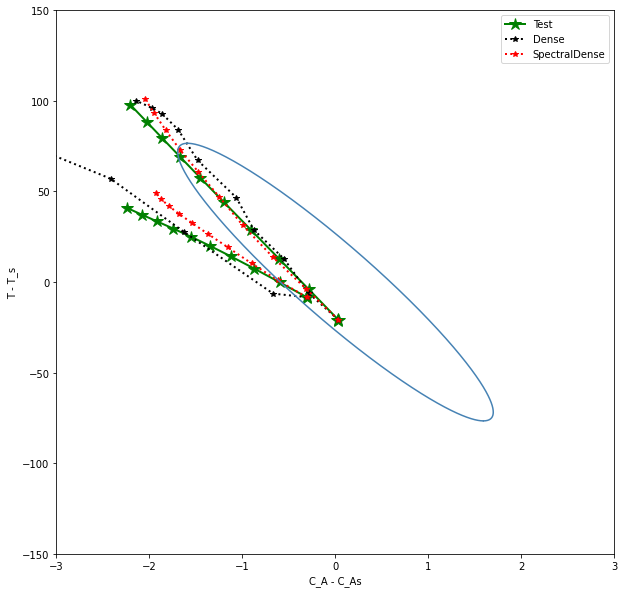

: 

In [ ]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""

dense_model = tf.keras.models.load_model("Dense , Hidden Layers : [320, 320] noise : 0.1.h5")
spectral_model = tf.keras.models.load_model("SpectralDense , Hidden Layers : [320, 320] noise : 0.1.h5")


"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


plt.figure(figsize=(10,10))

num_trajectories = 2
num_steps = 10
# plot the first 10 samples and their trajectories
y_predict = np.zeros((num_trajectories,num_steps,2))
y_test_trajectory = np.zeros((num_trajectories,num_steps,2))



start_list = np.random.randint(0,100,(num_trajectories,))






def X_to_Y(data):
    x = scaler_X.inverse_transform(data)
    xdata = np.array(x[0,2:4]).reshape((1,2)).copy()
    y = np.zeros((1,2))
    y[0,0] = xdata[0,1]
    y[0,1] = xdata[0,0]
    y = scaler_y.transform(y)
    return y

def Y_to_X(data):
    y = scaler_y.inverse_transform(data)
    x = np.zeros((1,4))
    ydata = y.copy()
    x[0,3] = ydata[0,0]
    x[0,2] = ydata[0,1] 
    x = scaler_X.transform(x)
    return x

print(X_test[0,0:4].reshape((1,4)).copy())
y = X_to_Y(X_test[0,0:4].reshape((1,4)).copy())
print(y)
print(Y_to_X(y))


def predict_trajectory(model, start_list):
    num_trajectories = len(start_list)
    y_predict = np.zeros((num_trajectories,num_steps,2))
    for k in range(num_trajectories):
        idx = start_list[k]
        curr_state = X_test[idx,0:4].reshape((1,4)).copy()
        y_predict[k,0,0] = X_to_Y(curr_state)[0,0]
        y_predict[k,0,1] =  X_to_Y(curr_state)[0,1]

        for j in range(1,num_steps):
            y_predict[k,j,:] = model.predict(np.array(curr_state))
            curr_state[0,3] = Y_to_X(y_predict[k,j].reshape((1,2)))[0,3]
            curr_state[0,2] = Y_to_X(y_predict[k,j].reshape((1,2)))[0,2]
        y_predict[k] = scaler_y.inverse_transform(y_predict[k])
    return y_predict 






def ground_truth_trajectory(start_list):
    for k in range(num_trajectories):
        idx = start_list[k]
        curr_state = X_test[idx,0:4].reshape((1,4)).copy()
        y_test_trajectory[k,0,0] = X_to_Y(curr_state)[0,0]
        y_test_trajectory[k,0,1] =  X_to_Y(curr_state)[0,1]


        for j in range(1,num_steps):
            curr_state_int = scaler_X.inverse_transform(curr_state)
            C_A_initial = curr_state_int[0,3]
            T_initial = curr_state_int[0,2]
            C_A0 = curr_state_int[0,0]
            Q = curr_state_int[0,1]
            C_A, T= CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)

            y_test_trajectory[k,j,:] = scaler_y.transform( np.array([C_A,T]).reshape(1,2) )
            curr_state[0,3] = Y_to_X(y_test_trajectory[k,j].reshape((1,2)))[0,3]
            curr_state[0,2] = Y_to_X(y_test_trajectory[k,j].reshape((1,2)))[0,2]
        y_test_trajectory[k] = scaler_y.inverse_transform(y_test_trajectory[k])
        
    return y_test_trajectory




X_plot = np.zeros(X_test.shape)
y_test_trajectory = ground_truth_trajectory(start_list)

for k in range(num_trajectories):
    X_plot[k,0:4] = scaler_X.inverse_transform(X_test[start_list[k]].reshape((1,4)))
    



for i in range(num_trajectories):
    if i == 0:  # only add label to 1 data point
        plt.plot([X_plot[i, -1]], [X_plot[i, -2]], marker="*", markersize=15, color='green')
        plt.plot(y_test_trajectory[i, :, 0], y_test_trajectory[i, :, 1], marker="*", markersize=12,color='green', lw=2, label='Test')
    else:
        plt.plot(X_plot[i, -1], X_plot[i, -2], marker="*", markersize=15, color='green')
        plt.plot(y_test_trajectory[i, :, 0], y_test_trajectory[i, :, 1], marker="*",markersize=12, color='green', lw=2)


model_list = [dense_model, spectral_model]
color_list = ['black', 'red']
name_list = ['Dense', 'SpectralDense']

for k in range(len(model_list)):
    model = model_list[k]
    color = color_list[k]
    name = name_list[k]
    y_predict = predict_trajectory(model, start_list)
    for i in range(num_trajectories):
        if i == 0:  # only add label to 1 data point
            plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], marker="*", color=color, lw=2, ls=':', label=name)
        else:
            plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], marker="*", color=color, lw=2, ls=':')


    
# plot stability region        
plt.plot(x_lower, y_plot, color='steelblue')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-150, 150])
plt.xlim([-3, 3])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()